# Mushroom Classification


# Context

Although this dataset was originally contributed to the UCI Machine Learning repository nearly 30 years ago, mushroom hunting (otherwise known as "shrooming") is enjoying new peaks in popularity. Learn which features spell certain death and which are most palatable in this dataset of mushroom characteristics. And how certain can your model be?

# Content

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

# Task

Predict whether a mushroom is `edible` or `poisonous`.

# Approach

* Data Exploratory Analysis
* Data Formatting
* Experimentation
* Conclusion


In [14]:
# Import tools

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Classification

# Regular Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Ensemble Models from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import plot_roc_curve

# Data Standardization
from sklearn.preprocessing import StandardScaler

# Data Encoding
from sklearn.preprocessing import LabelEncoder

In [2]:
# Function for computing cross-validated evaluation metrics

def cross_validation_report_regression(model, X_train, y_train, k):
    '''
    This function computes the cross-validated
    R2 score, MAE and MSE for a regression model accross k folds.
    '''
    
    cross_r2 = cross_val_score(model, X_train, y_train, cv=k, scoring="r2")
    cross_mae = cross_val_score(model, X_train, y_train, cv=k, scoring="neg_mean_absolute_error")
    cross_mse = cross_val_score(model, X_train, y_train, cv=k, scoring="neg_mean_squared_error")
    cross_rmse = cross_val_score(model, X_train, y_train, cv=k, scoring="neg_root_mean_squared_error")
    
    metrics = {"R2": cross_r2.mean(),
               "Mean Absolute Error": (cross_mae.mean())*-1,
               "Mean Squared Error": (cross_mse.mean())*-1,
               "Root Mean Squared Error": (cross_rmse.mean())*-1}
    return metrics


def test_eval_reg(y_test, y_preds):
    '''
    This function evaluates the predictions made by
    a Regression model on the test set.
    '''
    r2 = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return {"R2": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

def cross_validation_report_clf(model, X_train, y_train, k):
    '''
    This function computes the cross-validated
    Accuracy, Precision, Recall, F1-score and AUC Score for
    a Classification model accross k folds.
    '''
    
    cross_acc = cross_val_score(model, X_train, y_train, cv=k, scoring="accuracy")
    cross_prec = cross_val_score(model, X_train, y_train, cv=k, scoring="precision")
    cross_recall = cross_val_score(model, X_train, y_train, cv=k, scoring="recall")
    cross_f1 = cross_val_score(model, X_train, y_train, cv=k, scoring="f1")
    cross_auc = cross_val_score(model, X_train, y_train, cv=k, scoring="roc_auc")
    
    metrics = {"Mean Accuracy": cross_acc.mean(),
               "Precision": cross_prec.mean(),
               "Recall": cross_recall.mean(),
               "F1-Score": cross_f1.mean(),
               "AUC Score": cross_auc.mean()}
    return metrics


def test_eval_clf(y_test, y_preds):
    '''
    This function evaluates the predictions made by
    a Classification model on the test set.
    '''
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    auc = roc_auc_score(y_test, y_preds)
    
    print("Results of evaluation on test data")
    return {"Accuracy": acc, "Precision": prec, "Recall": recall, "F1-score": f1, "AUC score": auc}

def plot_confusion_matrix(y_test, y_preds, colormap):
    '''
    This function plots a Confusion Matrix using
    Seaborn's heatmap.
    '''
    sns.set(font_scale=1.2)
    log_reg_conf = confusion_matrix(y_test, y_preds)
    sns.heatmap(log_reg_conf, annot=True, fmt='d', linewidths=.5,  
                cmap=colormap, cbar=False)
    plt.ylabel('true label')
    plt.xlabel('predicted label');
    

def plot_corr_matrix(data, color):
    '''
    This function plots a correlation matrix for an input
    DataFrame with Seaborn's heatmap
    '''
    plt.figure(figsize=(12,12))
    sns.set(font_scale=1.2)
    sns.heatmap(data.corr(),cmap=color, annot=True)

def scatter_y(y_test, predicted_y):
    """Scatter-plot the predicted vs true number of rings
    
    Plots:
       * predicted vs true number of rings
       * perfect agreement line
       * +2/-2 number dotted lines

    Returns the root mean square of the error
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(y_test, predicted_y, '.k', color='salmon')
    
    ax.plot([0, 30], [0, 30], '--k', color='darkblue', linewidth=2)
    ax.plot([0, 30], [2, 32], ':k')
    ax.plot([2, 32], [0, 30], ':k')
    
    rms = (y_test - predicted_y).std()
    
    ax.text(25, 3,
            "Root Mean Square Error = %.2g" % rms,
            ha='right', va='bottom')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    ax.set_xlabel('True Number of Rings')
    ax.set_ylabel('Predicted Number of Rings')
    
    return rms

In [4]:
# Import data
df = pd.read_csv("../data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [9]:
# Check columns in data
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [11]:
# Check missing values
df.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [43]:
df['cap-shape'].value_counts()

x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64

# Exploratory Data Analysis

### Encoding the data

In [17]:
encoded_data = df.copy()
encoder = LabelEncoder()
for i in df.columns:
    encoded_data[i] = encoder.fit_transform(encoded_data[i])

encoded_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Text(0.5, 1.0, 'Distribution of Mushrooms')

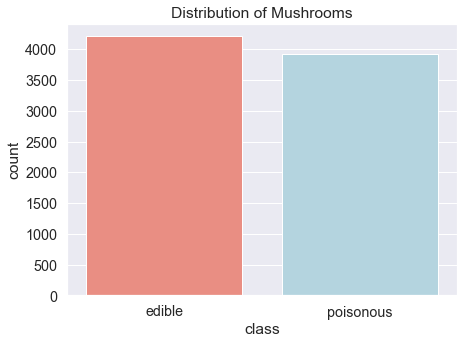

In [29]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(7, 5))
sns.countplot(x='class', data=encoded_data, palette=['salmon', 'lightblue'])
plt.xticks(ticks=[0, 1], labels=('edible', 'poisonous'))
plt.title("Distribution of Mushrooms")

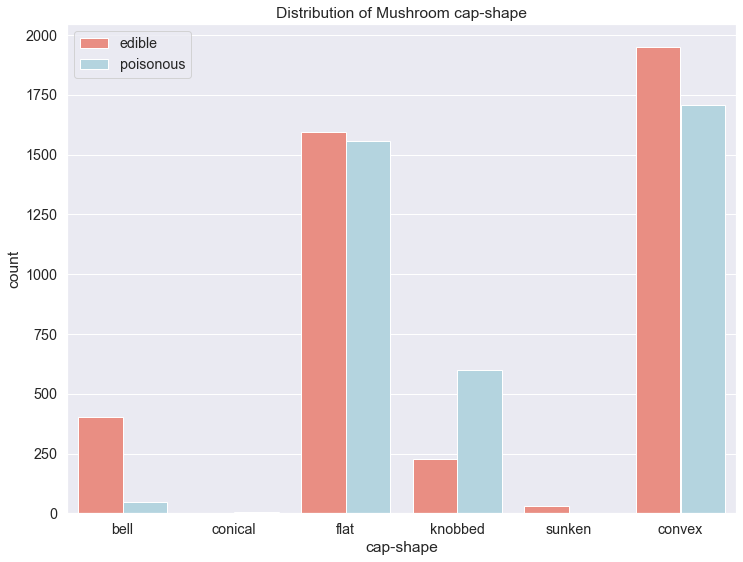

In [49]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(12, 9))

sns.countplot(x='cap-shape', hue='class', data=encoded_data, palette=['salmon', 'lightblue'])

plt.title("Distribution of Mushroom cap-shape")
plt.legend(('edible', 'poisonous'), loc=2)
plt.xticks([0,1,2,3,4,5], ['bell', 'conical', 'flat', 'knobbed', 'sunken', 'convex']);

In [55]:
df['cap-surface'].value_counts()

y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64

In [56]:
encoded_data['cap-surface'].value_counts()

3    3244
2    2556
0    2320
1       4
Name: cap-surface, dtype: int64

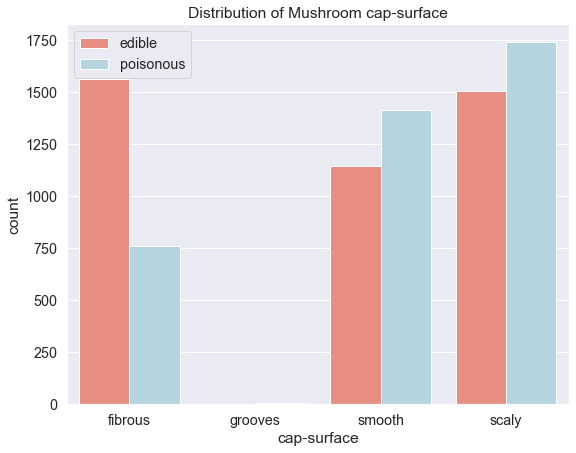

In [59]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(9, 7))

sns.countplot(x='cap-surface', hue='class', data=encoded_data, palette=['salmon', 'lightblue'])

plt.title("Distribution of Mushroom cap-surface")
plt.legend(('edible', 'poisonous'), loc=0)
plt.xticks([0,1,2,3], ['fibrous', 'grooves', 'smooth', 'scaly']);

In [60]:
X = encoded_data.drop("class", axis=1)
y = encoded_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Experimentation

In [63]:
# baseline logistic regression

lg_clf = LogisticRegression(max_iter=500)
lg_clf.fit(X_train, y_train)
y_preds = lg_clf.predict(X_test)
test_eval_clf(y_test, y_preds)

Results of evaluation on test data


{'Accuracy': 0.9491386382280558,
 'Precision': 0.9606837606837607,
 'Recall': 0.9351081530782029,
 'F1-score': 0.9477234401349073,
 'AUC score': 0.9489456622996193}

In [64]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1236
           1       0.96      0.94      0.95      1202

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438



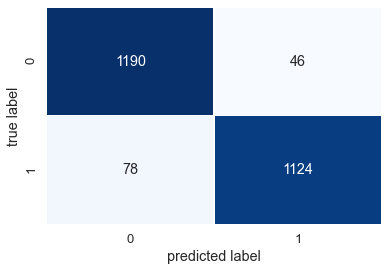

In [67]:
plot_confusion_matrix(y_test, y_preds, colormap='Blues')

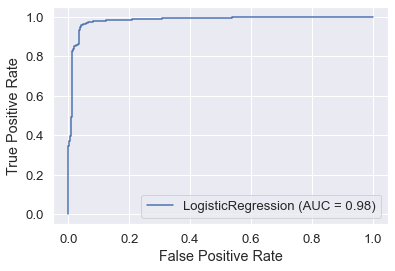

In [69]:
plot_roc_curve(lg_clf, X_test, y_test)

# Try SVC

In [70]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_preds = svm_clf.predict(X_test)
test_eval_clf(y_test, y_preds)

Results of evaluation on test data


{'Accuracy': 0.9864643150123051,
 'Precision': 0.9991460290350128,
 'Recall': 0.9733777038269551,
 'F1-score': 0.986093552465234,
 'AUC score': 0.986284321169141}

In [71]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1236
           1       1.00      0.97      0.99      1202

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438



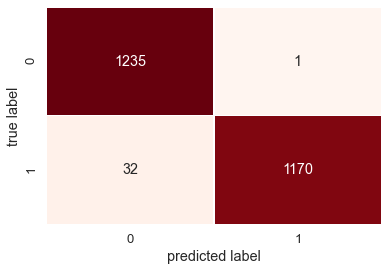

In [72]:
plot_confusion_matrix(y_test, y_preds, colormap='Reds')